In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
plt.style.use('ggplot')
np.set_printoptions(threshold=sys.maxsize)

In [2]:
def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

def payoff(S, strike, type='call'):
    if type=='call':
        return np.maximum(S - strike, 0)
    if type=='put':
        return np.maximum(strike-S, 0)

### Task 1

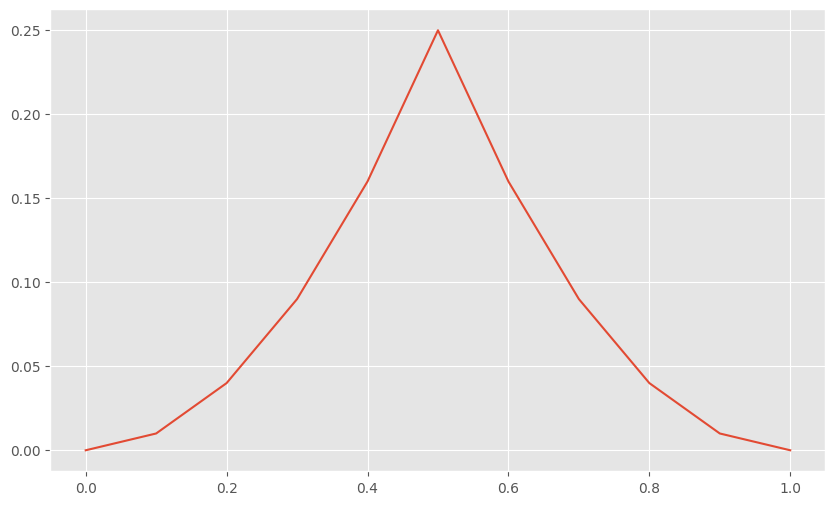

In [3]:
sigma = np.sqrt(0.2)  
L = 1  
T = 1 
Nx = 10
Nt = 10
dx = L / Nx 
dt = T / Nt  

U = np.zeros((Nx+1, Nt+1))

x = np.linspace(0, L, Nx+1)
U[:, 0] = x**2 * (x <= 0.5) + (1 - x)**2 * (x > 0.5)

for i in range(0, Nt):
    for j in range(1, Nx):
        U[j, i+1] = ((dt / (dx ** 2)) * ((sigma ** 2) / 2)) * U[j+1, i] + ((1- (dt * (sigma ** 2) / (dx ** 2)))) * U[j,i] + ((dt / (dx ** 2)) * ((sigma ** 2) / 2)) * U[j-1, i]
        
plt.figure(figsize=(10, 6))
plt.plot(x, U[:, 0])
plt.show()

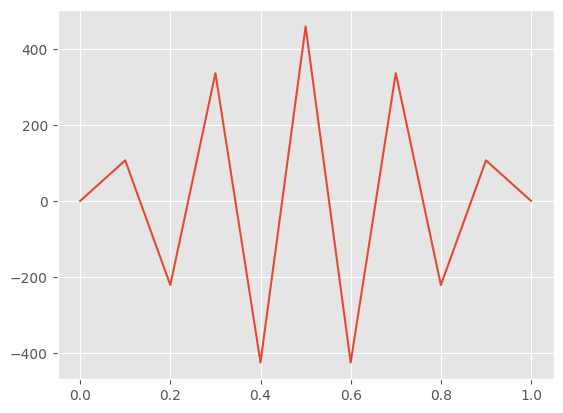

In [4]:
plt.plot(x, U[:, -1], label='Condition at T=1')

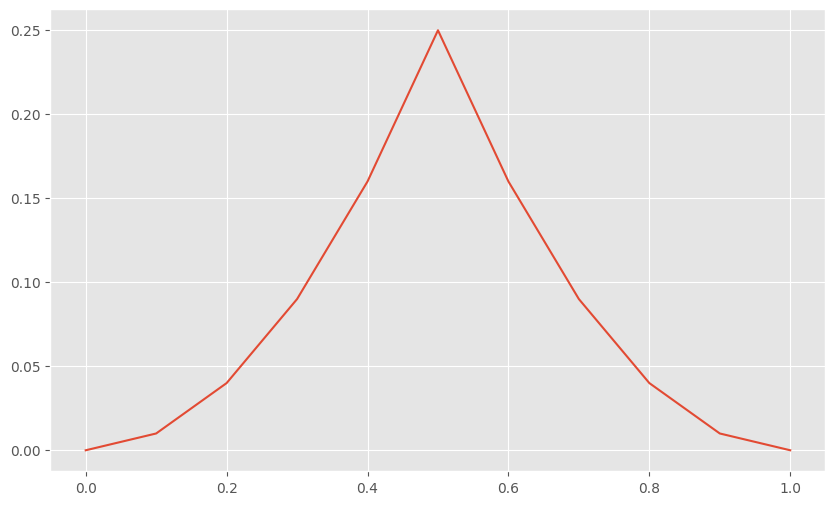

In [5]:
sigma = np.sqrt(0.2)  
L = 1  
T = 1 
Nx = 10
Nt = 1000
dx = L / Nx 
dt = T / Nt  

U = np.zeros((Nx+1, Nt+1))

x = np.linspace(0, L, Nx+1)
U[:, 0] = x**2 * (x <= 0.5) + (1 - x)**2 * (x > 0.5)

for i in range(0, Nt):
    for j in range(1, Nx):
        U[j, i+1] = ((dt / (dx ** 2)) * ((sigma ** 2) / 2)) * U[j+1, i] + ((1- (dt * (sigma ** 2) / (dx ** 2)))) * U[j,i] + ((dt / (dx ** 2)) * ((sigma ** 2) / 2)) * U[j-1, i]
        
plt.figure(figsize=(10, 6))
plt.plot(x, U[:, 0], label='Initial Condition')
plt.show()

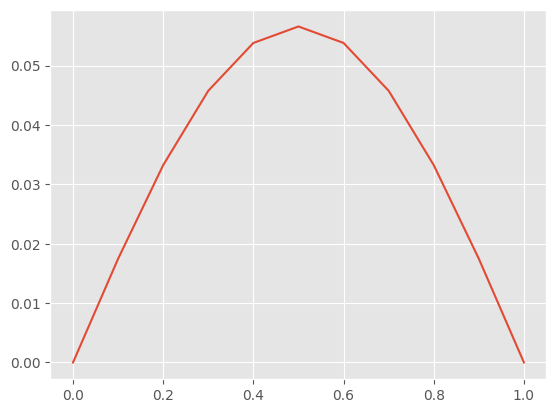

In [6]:
plt.plot(x, U[:, -1], label='Condition at T=1')

Now we want to show the stability for crank nikolson. For that we set up the matrix notation of the convergence

In [7]:
a = c = np.repeat(1, Nx - 2)
b = np.repeat(-2, Nx - 1)
A = tridiag(a, b, c)

np.identity(Nx-1)

theta = 0.5
sigma = np.sqrt(0.2)  
L = 1  
T = 1 
Nx = 10
Nt = 1000
dx = L / Nx 
dt = T / Nt  
alpha = dt / (dx ** 2)
U = np.zeros((Nx+1, Nt+1))
x = np.linspace(0, L, Nx+1)
U[:, 0] = x**2 * (x <= 0.5) + (1 - x)**2 * (x > 0.5)
I = np.identity(Nx-1)
M1 = I - ((alpha * theta * (sigma ** 2)) /  2) * A
M2 = I + ((alpha * (1 - theta) * (sigma ** 2)) /  2) * A
for i in range(0, Nt):
    b = np.dot(M2, U[1:-1,i])
    U[1:-1,i+1] = np.linalg.solve(M1, b)


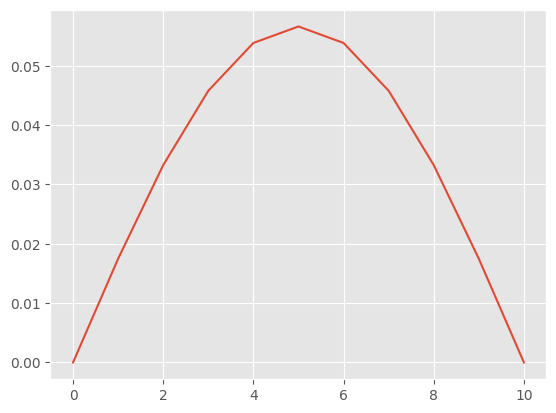

In [8]:
plt.plot(U[:,-1])

In [9]:
a = c = np.repeat(1, Nx - 2)
b = np.repeat(-2, Nx - 1)
A = tridiag(a, b, c)

np.identity(Nx-1)

theta = 0.5
sigma = np.sqrt(0.2)  
L = 1  
T = 1 
Nx = 10
Nt = 10
dx = L / Nx 
dt = T / Nt  
alpha = dt / (dx ** 2)
U = np.zeros((Nx+1, Nt+1))
x = np.linspace(0, L, Nx+1)
U[:, 0] = x**2 * (x <= 0.5) + (1 - x)**2 * (x > 0.5)
I = np.identity(Nx-1)
M1 = I - ((alpha * theta * (sigma ** 2)) /  2) * A
M2 = I + ((alpha * (1 - theta) * (sigma ** 2)) /  2) * A
for i in range(0, Nt):
    b = np.dot(M2, U[1:-1,i])
    U[1:-1,i+1] = np.linalg.solve(M1, b)

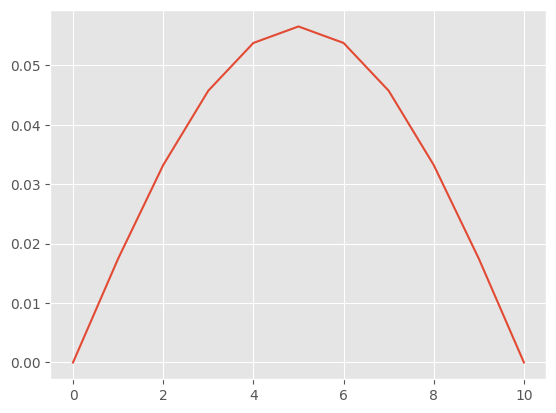

In [10]:
plt.plot(U[:,-1])

Here we can clearly see that with theta = 1/2 we do not experience instability in the function u. Hence, the discretization is correct. The initial condition remains the same as it was not changed in any discretization scheme.

### Task 2

In [11]:
def theta_crank_nicholson(type, expiration, sigma, r, strike, NAS, NTS, exercise_steps, spot_index):
    S_min = strike/3
    S_max = strike*2

    dS = (S_max-S_min)/NAS
    dt = expiration/NTS

    S = np.arange(0, NAS+1)* dS +S_min

    V = np.zeros((NAS + 1, NTS + 1))
    

    V[:, -1] = payoff(S=S, strike=strike, type=type)
    
    if type=='put':
        V[-1, :] = 0
        V[0, :] = np.maximum(strike - S_min, 0) * np.exp(-r * np.linspace(0, expiration, NTS + 1)[::-1])
    if type=='call':
        V[0, :] = 0
        V[-1, :] = np.maximum(S_max - strike, 0) * np.exp(-r * np.linspace(0, expiration, NTS + 1)[::-1])

    I = np.arange(0,NAS+1)

    alpha = 0.25 * dt * ((sigma**2) * (I**2) - r*I)
    beta = -dt * 0.5 * (sigma**2 * (I**2) + r)
    gamma = 0.25 * dt * (sigma**2 * (I**2) + r * I)

    ML = sparse.diags([-alpha[2:], 1-beta[1:], -gamma[1:]], [-1,0,1], shape=(NAS-1, NAS-1)).tocsc()
    MR = sparse.diags([alpha[2:], 1+beta[1:], gamma[1:]], [-1,0,1], shape=(NAS-1, NAS-1)).tocsc()

    for t in range(NTS - 1, -1, -1):
        boundary_t = np.zeros(NAS - 1)
        boundary_t[0] = alpha[1] * (V[0, t] + V[0, t + 1]) -alpha[0] * V[0, t + 1]
        boundary_t[-1] = gamma[NAS - 1] * (V[NAS, t] + V[NAS, t + 1])
        b = MR.dot(V[1:NAS, t + 1]) + boundary_t
        V[1:NAS, t] = spsolve(ML, b)
        #V[0, t] = 2 * V[1, t] - V[2, t]

        # Check for early exercise opportunity
        if t in exercise_steps:
            if type == 'put':
                exercise_value = np.maximum(strike - S[1:NAS], 0)
            elif type == 'call':
                exercise_value = np.maximum(S[1:NAS] - strike, 0)
            V[1:NAS, t] = np.maximum(V[1:NAS, t], exercise_value)


    asset_range = np.arange(0, NAS + 1) * dS  + S_min  # Asset price range
    time_steps = np.arange(0, NTS + 1) * dt
    rounded_time_steps = np.round(time_steps, decimals=3)
    df = pd.DataFrame(V, index=asset_range, columns=rounded_time_steps).round(3)
    
    return df.loc[spot_index, 0], S[spot_index]

In [12]:
K =100
sigma = 0.2
r = 0.1
expiration = 1
NAS = 200
NTS = 300
type = "call"
spot_index = 150

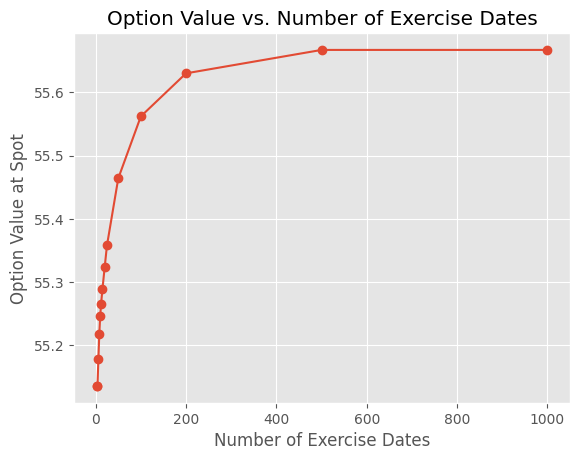

In [13]:
# Define number of exercise dates
exercise_steps = [2, 4, 6, 8, 10, 12, 15, 20, 25, 50, 100, 200, 500, 1000]  # Varying number of exercise dates
option_values = []

for num_exercises in exercise_steps:
    exercise_dates = np.linspace(0, NTS, num_exercises, dtype=int)
    option_value, spot = theta_crank_nicholson('call', 1, 0.25, 0.1, 100, 250, 100, exercise_dates, 150)
    option_values.append(option_value)

plt.plot(exercise_steps, option_values, marker='o')
plt.xlabel('Number of Exercise Dates')
plt.ylabel('Option Value at Spot')
plt.title('Option Value vs. Number of Exercise Dates')
plt.grid(True)
plt.show()

We can clearly see that the more exercise dates there are, the more expensive the bermudan option will be. If we take the limit of exercise dates then the value will approach an american option. In the plot we can see. In this figure we can also clearly see, that any bermudan option with the same parameters as a european call, is more expensive than the european call, as zero exercises dates is the lower bound of the set of bermudan option values.

In [14]:
def american_option_price_binomial(s_0,r,sigma,K,T,N, payoff):
  tau = T/N 
  R = 1 + r*tau
  u = np.exp(sigma*np.sqrt(tau))
  d = np.exp(-sigma*np.sqrt(tau))
  q = (np.exp(r*tau)-d)/(u-d)
  time = []

  for k in range(N+1):
    asset_price = (u**(N-k))*(d**k)*s_0
    time.append(payoff(asset_price,K))

  while len(time) > 1:
    for k in range(len(time)-1):
      tree_val = (q*time[k] + (1-q)*time[k+1])/R
      underlying_val = s_0*(u**(len(time)-1-k))*(d**(k+1)) 
      time[k] = max(tree_val, underlying_val - K)
    time.pop()
  return time[0]

In [15]:
american_option_price_binomial(158.33333333333331,0,sigma,K,1,1000, payoff)

58.42555375841696

The american binomial option should be the upper bound of the value of the limit of exercise dates for the value of the bermudan option. The convergence factor remains intact.

In [16]:
def theta_crank_nicholson(type, expiration, sigma, r, strike, NAS, NTS, exercise_steps, spot_index):
    S_min = strike/3
    S_max = strike*2

    dS = (S_max-S_min)/NAS
    dt = expiration/NTS

    S = np.arange(0, NAS+1)* dS +S_min

    V = np.zeros((NAS + 1, NTS + 1))
    

    V[:, -1] = payoff(S=S, strike=strike, type=type)
    
    if type=='put':
        V[-1, :] = 0
        V[0, :] = np.maximum(strike - S_min, 0) * np.exp(-r * np.linspace(0, expiration, NTS + 1)[::-1])
    if type=='call':
        V[0, :] = 0
        V[-1, :] = np.maximum(S_max - strike, 0) * np.exp(-r * np.linspace(0, expiration, NTS + 1)[::-1])

    I = np.arange(0,NAS+1)

    alpha = 0.25 * dt * ((sigma**2) * (I**2) - r*I)
    beta = -dt * 0.5 * (sigma**2 * (I**2) + r)
    gamma = 0.25 * dt * (sigma**2 * (I**2) + r * I)

    ML = sparse.diags([-alpha[2:], 1-beta[1:], -gamma[1:]], [-1,0,1], shape=(NAS-1, NAS-1)).tocsc()
    MR = sparse.diags([alpha[2:], 1+beta[1:], gamma[1:]], [-1,0,1], shape=(NAS-1, NAS-1)).tocsc()

    for t in range(NTS - 1, -1, -1):
        boundary_t = np.zeros(NAS - 1)
        boundary_t[0] = alpha[1] * (V[0, t] + V[0, t + 1]) -alpha[0] * V[0, t + 1]
        boundary_t[-1] = gamma[NAS - 1] * (V[NAS, t] + V[NAS, t + 1])
        b = MR.dot(V[1:NAS, t + 1]) + boundary_t
        V[1:NAS, t] = b @ sparse.linalg.inv(ML)
        #V[0, t] = 2 * V[1, t] - V[2, t]

        # Check for early exercise opportunity
        if t in exercise_steps:
            if type == 'put':
                exercise_value = np.maximum(strike - S[1:NAS], 0)
            elif type == 'call':
                exercise_value = np.maximum(S[1:NAS] - strike, 0)
            V[1:NAS, t] = np.maximum(V[1:NAS, t], exercise_value)


    asset_range = np.arange(0, NAS + 1) * dS  + S_min  # Asset price range
    time_steps = np.arange(0, NTS + 1) * dt
    rounded_time_steps = np.round(time_steps, decimals=3)
    df = pd.DataFrame(V, index=asset_range, columns=rounded_time_steps).round(3)
    
    return df.loc[spot_index, 0], S[spot_index]

In [17]:
K =100
sigma = 0.2
r = 0.0
q = 0
expiration = 1
NAS = 200
NTS = 300
type = "call"
exercise_steps = []
spot_index = 150

option, spot= theta_crank_nicholson(type = type, strike = K, sigma = sigma, r = r, 
                             expiration = expiration, 
                             NAS = NAS, NTS = NTS, exercise_steps=exercise_steps, spot_index=spot_index)
option, spot

(55.602, 158.33333333333331)

As we can see the operation is taking signigicantly longer, since the system is not immediatly solved, but rather the matrix needs to be inverted first.

Solving the system: 

$$ Ax = b $$

remains to be the fastest option for computation.